In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def parse_mdtest(files):
    r = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)
            for line in data['stdout_lines']:
                if "started" in line: start = line.split()[4]
                if "finished" in line: end = line.split()[4]
            r.append(to_seconds(end) - to_seconds(start))
    return r

# Get the speed of creating files in parallel
def parse_creates(dname):
    runs = []
    for fname in glob.glob(dname + '*/100000/summary-stream.txt'):
        with open(fname) as f:
            d = pd.read_csv(f, names=['job', 'time', 'create'])
            d = d[d['job'] == 'create']
            runs.append(float(d['create'].apply(to_seconds)))
    return runs

def parse_decoupled(runs):
    for run in runs:
        d = pd.read_csv("../results-run"+str(run)+"/summary.txt", names=csvhead)
        if run == 0: df = d
        df['merge-run-' + str(run)] = d['runtime'].apply(to_seconds)
    return df

def parse_rpcs(nclient):
    rpcs = pd.DataFrame(columns=["# of Clients", "rpcs"])
    for i in nclient:    
        if i < 20:
            j1   = parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients" + str(i) + "/*isolated*"))
        else: # the max value we can scale to is 18
            j1   = parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients18/*isolated*"))
        rpcs.loc[len(rpcs)] = [i, j1] 
    return rpcs

def tput(df, nclient):
    nfiles = [100000*c for c in nclient]
    return nfiles/df

,clients,RPCs,decoupled: create,decoupled: create+merge
4,1,191.000000,21.407611,6.113357
3,10,669.400000,75.027513,5.088099
2,20,1257.666667,140.961462,5.180821
1,30,1257.666667,140.961462,3.558520
0,40,1257.666667,140.961462,2.717933


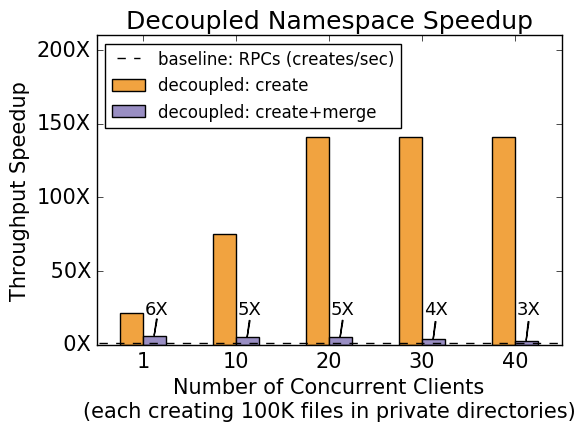

In [5]:
csvhead = ['job', 'nfiles', '# of Clients', 'time', 'runtime']
nclient = [40, 30, 20, 10, 1]
nfiles  = [c*100000 for c in nclient]
runs    = [0, 1, 2]
createL = "decoupled: create"; mergeL = "decoupled: create+merge"
plt_val = [createL, mergeL]
plt_std = [createL+'_stds', mergeL+'_stds']#, 'decoupled_stds']
colors  = ['#f1a340', '#998ec3', '#f7f7f7']

# these all return runtimes
rpcs = parse_rpcs(nclient)
crts = parse_creates('../../cudele-mechanisms/results-cloudlab-nostream-run')
decp = parse_decoupled(runs)

# find mean and normalize
mean = pd.DataFrame(); stds = pd.DataFrame()
mean['clients']   = rpcs['# of Clients'].astype(int)
mean['RPCs']    = rpcs['rpcs'].apply(np.mean)
mean[createL]   = np.ones(len(mean))*np.mean(crts)
mean[mergeL]    = decp[['merge-run-0', 'merge-run-1', 'merge-run-2']].mean(axis=1) + mean[createL]
mean[createL]   = tput(mean[createL], nclient)/ tput(mean['RPCs'], nclient)
mean[mergeL]    = tput(mean[mergeL], nclient) / tput(mean['RPCs'], nclient)

font = {'size'   : 15}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1)
mean = mean.iloc[::-1]
mean[[createL, mergeL]].plot.bar(ax=ax, color=['#f1a340', '#998ec3', '#f7f7f7'])
ax.plot([-4, 5], [1, 1], color='black', ls='--', label='baseline: RPCs (creates/sec)')

# annotate
i = 0
args = {'horizontalalignment': 'center', 'verticalalignment': 'top', 'fontsize': 13}
args['arrowprops'] = dict(facecolor='black', headwidth=0.5, width=0.5)#, shrink=1)
for j in mean[mergeL]:
    ax.annotate(str(int(round(j))) + 'X', xy=(i+0.12, j), xytext=(i+0.15, 30), **args)
    i += 1
#args['arrowprops'] = dict(facecolor='black', headwidth=10, width=1, shrink=1)
#ax.annotate('baseline: RPCs', xy=(0.38, 1), xytext=(0.7, 100), **args)

# format
ax.set_xticklabels(mean['clients'], rotation=0)
ax.set_ylim(-0.5, 210)
#ax.set_yscale('log')
ax.set_title("Decoupled Namespace Speedup")
ax.set_xlabel("Number of Concurrent Clients\n(each creating 100K files in private directories)")
ax.set_ylabel("Throughput Speedup")
ax.set_yticklabels(['{:3.0f}X'.format(x) for x in ax.get_yticks()])
ax.legend(loc='upper left', fontsize=12)
fig.savefig('../../../paper/graphs/mergescale.png', bbox_inches='tight', dpi=400)
mean

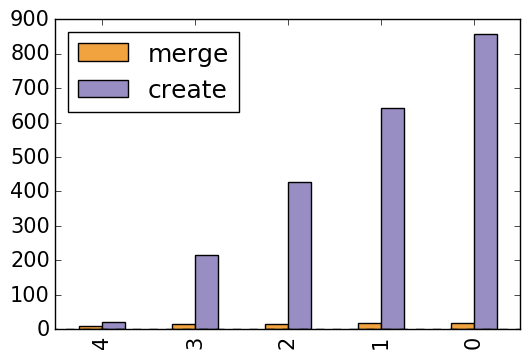

In [4]:
# these all return runtimes
rpcs = parse_rpcs(nclient)
crts = parse_creates('../../cudele-mechanisms/results-cloudlab-nostream-run')
decp = parse_decoupled(runs)
mean = pd.DataFrame()
mean['clients'] = rpcs['# of Clients'].astype(int)
mean['RPCs']    = rpcs['rpcs'].apply(np.mean)
mean['create']  = np.ones(len(mean))*np.mean(crts)
mean['merge']   = decp[['merge-run-0', 'merge-run-1', 'merge-run-2']].mean(axis=1)

norm = mean[mean['clients'] == 1]['RPCs']
norm = float(100000/norm)
mean['merge']  = tput(mean['merge'], nclient) / norm
mean['create'] = tput(mean['create'], nclient)/ norm
mean = mean.iloc[::-1]

font = {'size'   : 15}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1)
mean[['merge', 'create']].plot.bar(ax=ax, color=['#f1a340', '#998ec3', '#f7f7f7'])
ax.plot([-4, 5], [1, 1], color='black', ls='--')

